# Notebook 9 — Two-Way DKL: Joint Race × Income Segregation

The **2-way DKL** extends the one-way metric by measuring how unevenly *joint*
(race, income) groups are distributed across census tracts within a metropolitan area.

## Formula

For each tract *i* and (race=*j*, income=*k*) cell:

$$\text{DKL}_{2\text{-way}}(i) = \sum_{j,k} p_{yz,i} \log_2 \frac{p_{yz,i}}{p_{yz}}$$

where $p_{yz,i} = P(\text{race}=j, \text{income}=k \mid \text{tract}=i)$ and
$p_{yz} = P(\text{race}=j, \text{income}=k)$ in the MSA.

This is equivalent to the KL divergence of the joint (race, income) distribution
in a tract from the MSA-level joint distribution.

## Decomposition

$$\text{Residual}(i) = \text{DKL}_{2\text{-way}}(i) - \text{DKL}_{\text{race}}(i) - \text{DKL}_{\text{income}}(i)$$

The residual captures sorting specific to particular *race × income* combinations —
the degree to which specific race groups at specific income levels are more
concentrated than either race or income alone would predict.

**Data**: ACS 5-year 2020, tables B19001A–I (household income by race/ethnicity)
at **census tract** level. These cross-tabulations are not published at block group level.

**Cities**: Atlanta, Chicago, Houston, New York (as in other notebooks)

In [1]:
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from census import Census

warnings.filterwarnings('ignore')

NOTEBOOK_DIR = Path().resolve()
PIPELINE_DIR = NOTEBOOK_DIR.parent
if str(PIPELINE_DIR) not in sys.path:
    sys.path.insert(0, str(PIPELINE_DIR))

from config import DATA_DIR, CENSUS_API_KEY, CITIES
from utils.cbsa_xwalk import get_cbsa_xwalk

sns.set_theme(style='whitegrid', font_scale=0.95)
YEAR = 2020

print(f'DATA_DIR : {DATA_DIR}')
print(f'CITIES   : {CITIES}')

DATA_DIR : /Users/bettencourt/Desktop/dkl-metric/pipeline/data
CITIES   : ['Chicago-Naperville-Elgin, IL-IN-WI', 'Houston-The Woodlands-Sugar Land, TX', 'Atlanta-Sandy Springs-Alpharetta, GA', 'New York-Newark-Jersey City, NY-NJ-PA']


In [2]:
# ── Config ────────────────────────────────────────────────────────────────────

# ACS tables B19001A-I: household income by race/ethnicity
RACE_TABLES = {
    'White (non-Hisp.)': 'B19001H',
    'Black':             'B19001B',
    'Native American':   'B19001C',
    'Asian':             'B19001D',
    'Pacific Islander':  'B19001E',
    'Other race':        'B19001F',
    'Two or more':       'B19001G',
    'Hispanic/Latino':   'B19001I',
}

INCOME_ITEMS = [f'{i:03d}' for i in range(2, 18)]   # 002–017 (excludes total)

INCOME_LABELS = {
    '002': '< $10K',    '003': '$10–15K',  '004': '$15–20K',  '005': '$20–25K',
    '006': '$25–30K',   '007': '$30–35K',  '008': '$35–40K',  '009': '$40–45K',
    '010': '$45–50K',   '011': '$50–60K',  '012': '$60–75K',  '013': '$75–100K',
    '014': '$100–125K', '015': '$125–150K','016': '$150–200K','017': '> $200K',
}

RACE_COLORS = {
    'White (non-Hisp.)': '#4393c3',
    'Black':             '#d6604d',
    'Hispanic/Latino':   '#74c476',
    'Asian':             '#fd8d3c',
    'Two or more':       '#9e9ac8',
    'Native American':   '#bdbdbd',
    'Pacific Islander':  '#a1d99b',
    'Other race':        '#bcbddc',
}

CITY_SHORT = {c: c.split(',')[0].split('-')[0].strip() for c in CITIES}
print('City labels:', list(CITY_SHORT.values()))

City labels: ['Chicago', 'Houston', 'Atlanta', 'New York']


In [3]:
# ── CBSA crosswalk → identify states needed ───────────────────────────────────

cbsa_xwalk = get_cbsa_xwalk(2020)

primary_names = [c.split(',')[0] for c in CITIES]
city_counties = cbsa_xwalk[
    cbsa_xwalk['cbsa_title'].str.contains('|'.join(primary_names), case=False, na=False)
].copy()

study_state_fips = sorted(city_counties['county_fips'].str[:2].unique().tolist())
print(f'States to download ({len(study_state_fips)}): {study_state_fips}')
print(city_counties.groupby('cbsa_title').size().rename('n_counties'))

States to download (8): ['13', '17', '18', '34', '36', '42', '48', '55']
cbsa_title
Atlanta-Sandy Springs-Alpharetta, GA     29
Chicago-Naperville-Elgin, IL-IN-WI       14
Houston-The Woodlands-Sugar Land, TX      9
New York-Newark-Jersey City, NY-NJ-PA    23
Name: n_counties, dtype: int64


In [4]:
# ── Download B19001A-I at tract level (cached) ────────────────────────────────

CACHE_PATH = DATA_DIR / 'two_way_dkl' / f'joint_race_income_tract_{YEAR}.parquet'
CACHE_PATH.parent.mkdir(parents=True, exist_ok=True)


def _build_variables():
    """Return list of all B19001A-I income variables (no E suffix)."""
    return [
        f'{table}_{item}'
        for table in RACE_TABLES.values()
        for item in INCOME_ITEMS
    ]


def _fetch_state(c_api, state_fips, variables, year):
    """Fetch one state, chunking variables into batches of 45."""
    chunk_size = 45
    chunks = [variables[i:i+chunk_size] for i in range(0, len(variables), chunk_size)]
    dfs = []
    for chunk in chunks:
        api_vars = [v + 'E' for v in chunk]   # ACS requires E suffix
        rows = c_api.acs5.state_county_tract(
            fields=['NAME'] + api_vars,
            state_fips=state_fips,
            county_fips=Census.ALL,
            tract=Census.ALL,
            year=year,
        )
        df = pd.DataFrame(rows)
        # strip E suffix from column names
        df = df.rename(columns={v + 'E': v for v in chunk})
        dfs.append(df)

    # merge chunks on shared id columns
    result = dfs[0]
    for extra in dfs[1:]:
        shared = [c for c in extra.columns if c in result.columns and c not in variables]
        result = result.merge(extra[shared + [v for v in extra.columns if v in variables]],
                              on=shared, how='left')
    result['tract_fips'] = (
        result['state'].astype(str).str.zfill(2) +
        result['county'].astype(str).str.zfill(3) +
        result['tract'].astype(str).str.zfill(6)
    )
    return result


def download_joint_data(year, state_fips_list, api_key):
    c_api = Census(api_key)
    variables = _build_variables()
    frames = []
    for sf in state_fips_list:
        print(f'  State {sf} …', end=' ', flush=True)
        try:
            df = _fetch_state(c_api, sf, variables, year)
            # convert to numeric
            for v in variables:
                if v in df.columns:
                    df[v] = pd.to_numeric(df[v], errors='coerce').fillna(0).clip(lower=0)
                else:
                    df[v] = 0.0
            # melt to long format
            id_cols = ['tract_fips']
            long = df[id_cols + variables].melt(
                id_vars=id_cols, var_name='variable', value_name='estimate'
            )
            long['race_group']    = long['variable'].apply(
                lambda v: next(k for k, t in RACE_TABLES.items() if t == v[:7])
            )
            long['income_item']   = long['variable'].str[-3:]
            long['income_label']  = long['income_item'].map(INCOME_LABELS)
            frames.append(long[['tract_fips','race_group','income_item','income_label','estimate']])
            print(f'{len(df):,} tracts')
        except Exception as e:
            print(f'ERROR: {e}')
    return pd.concat(frames, ignore_index=True)


if CACHE_PATH.exists():
    print('Loading from cache …')
    joint_raw = pd.read_parquet(CACHE_PATH)
else:
    print('Downloading joint race × income data (this takes a few minutes) …')
    joint_raw = download_joint_data(YEAR, study_state_fips, CENSUS_API_KEY)
    joint_raw.to_parquet(CACHE_PATH, index=False)

print(f'\nTotal rows: {len(joint_raw):,}')
joint_raw.head(3)

Loading from cache …



Total rows: 3,485,824


,tract_fips,race_group,income_item,income_label,estimate
0,13059001200,White (non-Hisp.),002,< $10K,67.0
1,13059001700,White (non-Hisp.),002,< $10K,5.0
2,13059001800,White (non-Hisp.),002,< $10K,58.0


In [5]:
# ── Filter to study cities + attach CBSA info ─────────────────────────────────

county_cbsa = cbsa_xwalk[['county_fips','cbsa_fips','cbsa_title']].drop_duplicates()

joint = joint_raw.copy()
joint['county_fips'] = joint['tract_fips'].str[:5]
joint = joint.merge(county_cbsa, on='county_fips', how='inner')

mask = joint['cbsa_title'].str.contains(
    '|'.join(primary_names), case=False, na=False
)
joint = joint[mask].copy()

def _city_label(title):
    for c in CITIES:
        if c.split(',')[0].lower() in title.lower():
            return CITY_SHORT[c]
    return title.split(',')[0]

joint['city_label'] = joint['cbsa_title'].apply(_city_label)

# Income category ordering
income_order = [INCOME_LABELS[k] for k in sorted(INCOME_LABELS)]
joint['income_label'] = pd.Categorical(joint['income_label'], categories=income_order, ordered=True)

print(f'Filtered rows: {len(joint):,}')
print(joint.groupby('city_label').agg(tracts=('tract_fips','nunique')))

Filtered rows: 1,330,432
            tracts
city_label        
Atlanta       1500
Chicago       2335
Houston       1606
New York      4953


In [6]:
# ── Compute tract- and CBSA-level aggregations ────────────────────────────────

joint['tract_joint']  = joint['estimate']
joint['tract_total']  = joint.groupby('tract_fips')['estimate'].transform('sum')
joint['tract_race']   = joint.groupby(['tract_fips','race_group'])['estimate'].transform('sum')
joint['tract_income'] = joint.groupby(['tract_fips','income_item'])['estimate'].transform('sum')

joint['cbsa_joint']   = joint.groupby(['cbsa_fips','race_group','income_item'])['estimate'].transform('sum')
joint['cbsa_total']   = joint.groupby('cbsa_fips')['estimate'].transform('sum')
joint['cbsa_race']    = joint.groupby(['cbsa_fips','race_group'])['estimate'].transform('sum')
joint['cbsa_income']  = joint.groupby(['cbsa_fips','income_item'])['estimate'].transform('sum')

print('Aggregations done. Sample:')
joint[['tract_fips','race_group','income_item','estimate','tract_total','cbsa_total']].head(5)

Aggregations done. Sample:


,tract_fips,race_group,income_item,estimate,tract_total,cbsa_total
29,13063040202,White (non-Hisp.),002,0.0,912.0,2232669.0
30,13063040203,White (non-Hisp.),002,0.0,1653.0,2232669.0
31,13063040204,White (non-Hisp.),002,0.0,2054.0,2232669.0
32,13063040302,White (non-Hisp.),002,10.0,2184.0,2232669.0
33,13063040306,White (non-Hisp.),002,0.0,1685.0,2232669.0


In [7]:
# ── Compute 2-way DKL and 1-way components ────────────────────────────────────

def safe_log2(num, denom):
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.where((num > 0) & (denom > 0), num / denom, np.nan)
        return np.where(np.isfinite(ratio) & (ratio > 0), np.log2(ratio), 0.0)


# Probabilities
T  = joint['tract_total'].values
CT = joint['cbsa_total'].values

p_yjzk_ni = np.where(T > 0,  joint['tract_joint'].values  / T,  0.0)
p_yjzk    = np.where(CT > 0, joint['cbsa_joint'].values   / CT, 0.0)
p_yj_ni   = np.where(T > 0,  joint['tract_race'].values   / T,  0.0)
p_yj      = np.where(CT > 0, joint['cbsa_race'].values    / CT, 0.0)
p_zk_ni   = np.where(T > 0,  joint['tract_income'].values / T,  0.0)
p_zk      = np.where(CT > 0, joint['cbsa_income'].values  / CT, 0.0)

# 2-way DKL component per (tract, race, income) row
joint['dkl_2way_jk']   = p_yjzk_ni * safe_log2(p_yjzk_ni, p_yjzk)

# 1-way components (deduplicated per unique pair before summing)
joint['dkl_race_j']    = p_yj_ni   * safe_log2(p_yj_ni,   p_yj)
joint['dkl_income_k']  = p_zk_ni   * safe_log2(p_zk_ni,   p_zk)

# ── Aggregate to tract level ──
tract_dkl = (
    joint.groupby(['tract_fips','cbsa_fips','cbsa_title','city_label'])
    .agg(dkl_2way=('dkl_2way_jk','sum'),
         tract_total=('tract_total','first'))
    .reset_index()
)

# 1-way race: one contribution per (tract, race) — take first row per group
race_1way = (
    joint.drop_duplicates(['tract_fips','race_group'])
    .groupby('tract_fips')['dkl_race_j'].sum()
    .rename('dkl_1way_race')
)
# 1-way income: one contribution per (tract, income)
income_1way = (
    joint.drop_duplicates(['tract_fips','income_item'])
    .groupby('tract_fips')['dkl_income_k'].sum()
    .rename('dkl_1way_income')
)

tract_dkl = tract_dkl.set_index('tract_fips').join(race_1way).join(income_1way).reset_index()
tract_dkl['residual'] = tract_dkl['dkl_2way'] - tract_dkl['dkl_1way_race'] - tract_dkl['dkl_1way_income']

print(f'Tract-level DKL: {len(tract_dkl):,} tracts')
tract_dkl.groupby('city_label')[['dkl_2way','dkl_1way_race','dkl_1way_income','residual']].median().round(4)

Tract-level DKL: 10,394 tracts


,dkl_2way,dkl_1way_race,dkl_1way_income,residual
city_label,,,,
Atlanta,1.4099,0.4570,0.4474,0.4408
Chicago,1.1445,0.4562,0.3360,0.3315
Houston,1.5631,0.4627,0.4984,0.5256
New York,1.3246,0.5603,0.3615,0.4089


In [8]:
# ── City-level summary: population-weighted means ─────────────────────────────

def weighted_mean(df, col, weight='tract_total'):
    w = df[weight].clip(lower=0)
    return (df[col] * w).sum() / w.sum() if w.sum() > 0 else np.nan

summary = (
    tract_dkl.groupby('city_label')
    .apply(lambda g: pd.Series({
        'DKL 2-way (joint race×income)': weighted_mean(g, 'dkl_2way'),
        'DKL 1-way race':               weighted_mean(g, 'dkl_1way_race'),
        'DKL 1-way income':             weighted_mean(g, 'dkl_1way_income'),
        'Residual (interaction)':       weighted_mean(g, 'residual'),
        'n_tracts':                     len(g),
    }))
    .reset_index()
)

print('Population-weighted mean DKL by city:')
summary.set_index('city_label').round(4)

Population-weighted mean DKL by city:


,DKL 2-way (joint race×income),DKL 1-way race,DKL 1-way income,Residual (interaction),n_tracts
city_label,,,,,
Atlanta,1.4396,0.5179,0.4749,0.4467,1500.0
Chicago,1.3331,0.6262,0.3773,0.3296,2335.0
Houston,1.5731,0.5026,0.5379,0.5325,1606.0
New York,1.4413,0.6357,0.4218,0.3838,4953.0


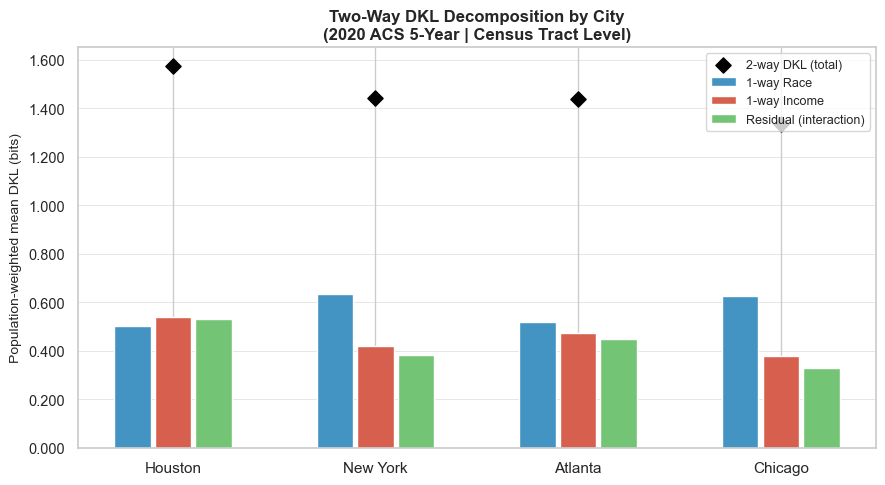

In [9]:
# ── Plot 1: City comparison — 2-way vs 1-way components ──────────────────────

metrics = [
    ('DKL 1-way race',               '#4393c3', '1-way Race'),
    ('DKL 1-way income',             '#d6604d', '1-way Income'),
    ('Residual (interaction)',        '#74c476', 'Residual (interaction)'),
]

cities_sorted = summary.sort_values('DKL 2-way (joint race×income)', ascending=False)['city_label'].tolist()

fig, ax = plt.subplots(figsize=(9, 5))

bar_w = 0.2
x = np.arange(len(cities_sorted))

for i, (col, color, label) in enumerate(metrics):
    vals = [summary.loc[summary['city_label']==c, col].values[0] for c in cities_sorted]
    ax.bar(x + (i-1)*bar_w, vals, width=bar_w*0.9, color=color, label=label, edgecolor='white')

# Overlay 2-way total as a dot
vals_2way = [summary.loc[summary['city_label']==c, 'DKL 2-way (joint race×income)'].values[0]
             for c in cities_sorted]
ax.scatter(x, vals_2way, color='black', zorder=5, s=60, label='2-way DKL (total)', marker='D')

ax.set_xticks(x)
ax.set_xticklabels(cities_sorted, fontsize=11)
ax.set_ylabel('Population-weighted mean DKL (bits)', fontsize=10)
ax.set_title(
    'Two-Way DKL Decomposition by City\n'
    '(2020 ACS 5-Year | Census Tract Level)',
    fontsize=12, fontweight='bold'
)
ax.legend(fontsize=9, loc='upper right')
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))
ax.grid(axis='y', linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

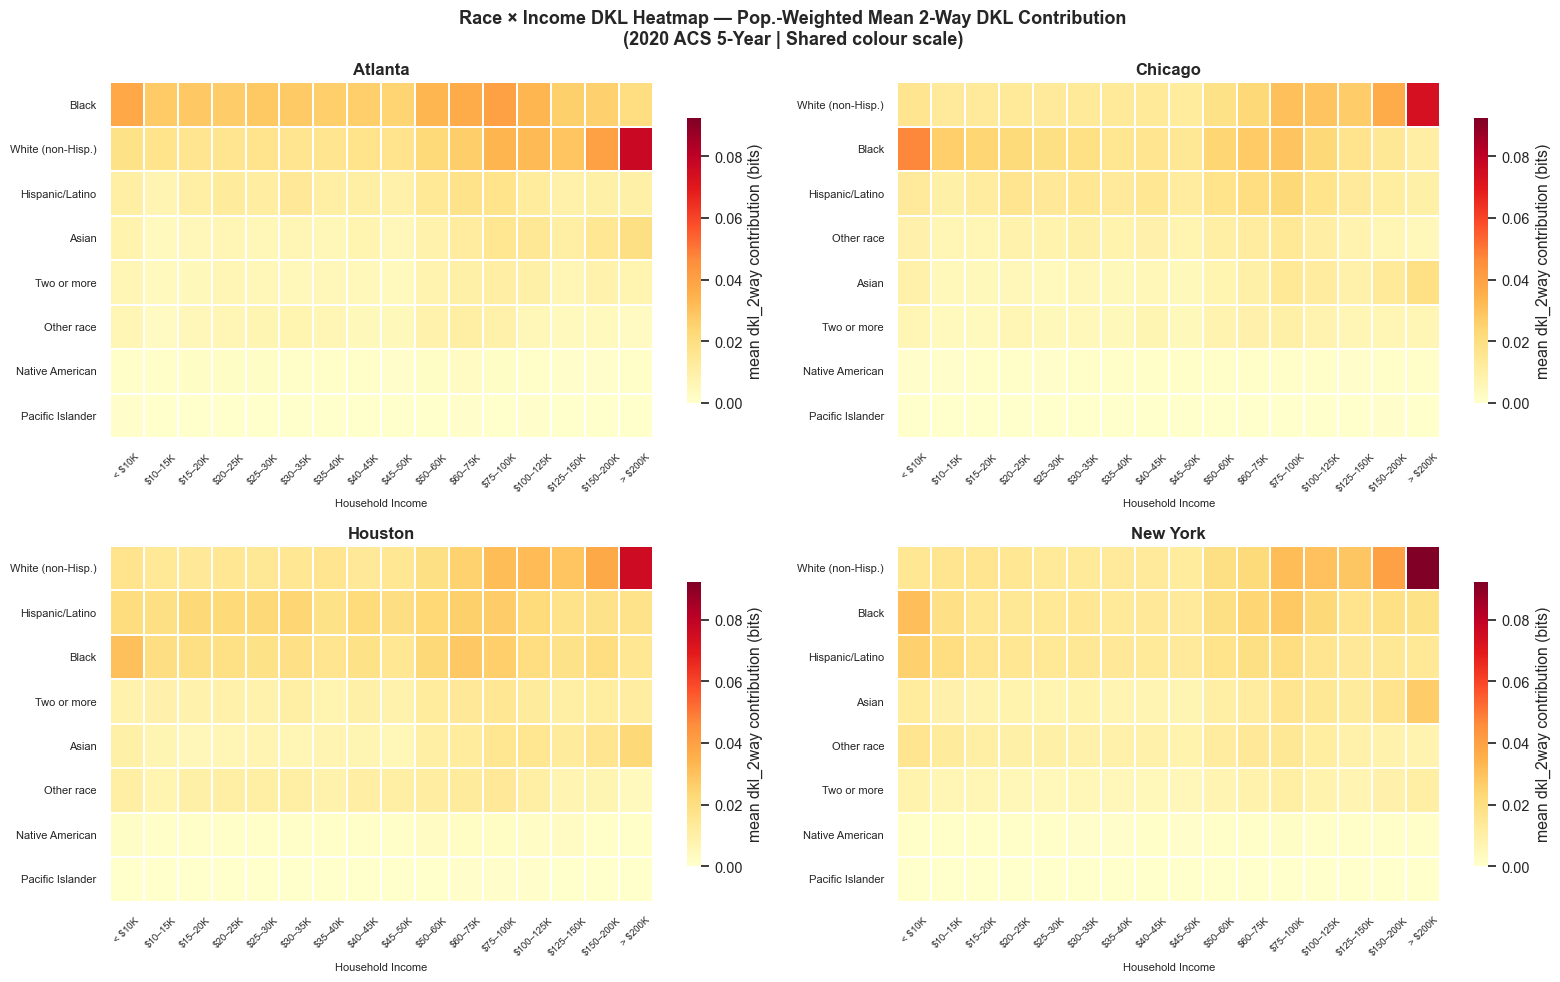

In [10]:
# ── Plot 2: Heatmap — race × income DKL matrix per city ──────────────────────
#
# For each (race, income) cell: population-weighted mean 2-way DKL contribution
# across all tracts in the city.

def cell_dkl_matrix(city):
    sub = joint[joint['city_label'] == city].copy()
    # weight by tract_total
    sub['w_dkl'] = sub['dkl_2way_jk'] * sub['tract_total']
    sub['w']     = sub['tract_total']
    agg = (
        sub.groupby(['race_group','income_label'], observed=True)
        .agg(w_dkl=('w_dkl','sum'), w=('w','sum'))
        .reset_index()
    )
    agg['mean_dkl'] = agg['w_dkl'] / agg['w'].replace(0, np.nan)
    pivot = agg.pivot(index='race_group', columns='income_label', values='mean_dkl')
    return pivot

cities_list = sorted(joint['city_label'].unique())
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

vmax = max(
    cell_dkl_matrix(c).max().max()
    for c in cities_list
)

for ax, city in zip(axes.flat, cities_list):
    pivot = cell_dkl_matrix(city)
    # reorder rows by total DKL
    race_order = pivot.sum(axis=1).sort_values(ascending=False).index.tolist()
    pivot = pivot.loc[race_order]

    sns.heatmap(
        pivot, ax=ax,
        cmap='YlOrRd', vmin=0, vmax=vmax,
        linewidths=0.3, linecolor='white',
        cbar_kws={'label': 'mean dkl_2way contribution (bits)', 'shrink': 0.8},
        fmt='.3f', annot=False
    )
    ax.set_title(city, fontsize=12, fontweight='bold')
    ax.set_xlabel('Household Income', fontsize=8)
    ax.set_ylabel('')
    ax.tick_params(axis='x', labelrotation=45, labelsize=7)
    ax.tick_params(axis='y', labelrotation=0, labelsize=8)

fig.suptitle(
    'Race × Income DKL Heatmap — Pop.-Weighted Mean 2-Way DKL Contribution\n'
    '(2020 ACS 5-Year | Shared colour scale)',
    fontsize=13, fontweight='bold'
)
plt.tight_layout()
plt.show()

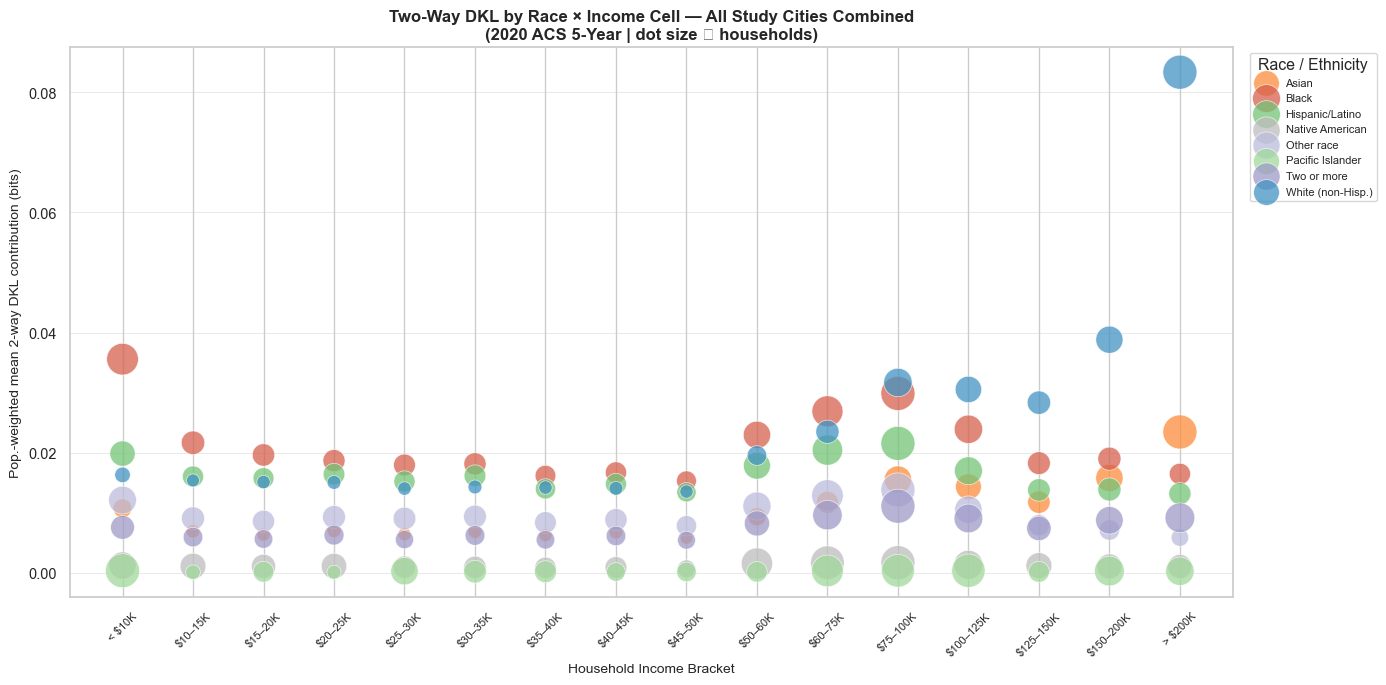

In [11]:
# ── Plot 3: Dot plot — 2-way DKL by (race, income) cell ──────────────────────
#
# Each dot = one (race, income) cell aggregated across all study cities.
# Size = number of households. Colour = race group.

dot_agg = (
    joint
    .groupby(['race_group','income_label'], observed=True)
    .agg(
        total_households=('estimate','sum'),
        w_dkl=('dkl_2way_jk', lambda s: (s * joint.loc[s.index,'tract_total']).sum()),
        w=('tract_total','sum'),
    )
    .reset_index()
)
dot_agg['mean_dkl'] = dot_agg['w_dkl'] / dot_agg['w'].replace(0, np.nan)
dot_agg = dot_agg.dropna(subset=['mean_dkl'])

fig, ax = plt.subplots(figsize=(14, 7))

for race, grp in dot_agg.groupby('race_group'):
    ax.scatter(
        grp['income_label'], grp['mean_dkl'],
        s=grp['total_households'] / grp['total_households'].max() * 600,
        color=RACE_COLORS.get(race, '#888'),
        alpha=0.75, label=race, edgecolors='white', linewidths=0.5, zorder=3
    )

ax.set_xlabel('Household Income Bracket', fontsize=10)
ax.set_ylabel('Pop.-weighted mean 2-way DKL contribution (bits)', fontsize=10)
ax.set_title(
    'Two-Way DKL by Race × Income Cell — All Study Cities Combined\n'
    '(2020 ACS 5-Year | dot size ∝ households)',
    fontsize=12, fontweight='bold'
)
ax.tick_params(axis='x', labelrotation=45, labelsize=8)
ax.grid(axis='y', linewidth=0.5, alpha=0.6)
ax.set_axisbelow(True)
ax.legend(title='Race / Ethnicity', fontsize=8, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

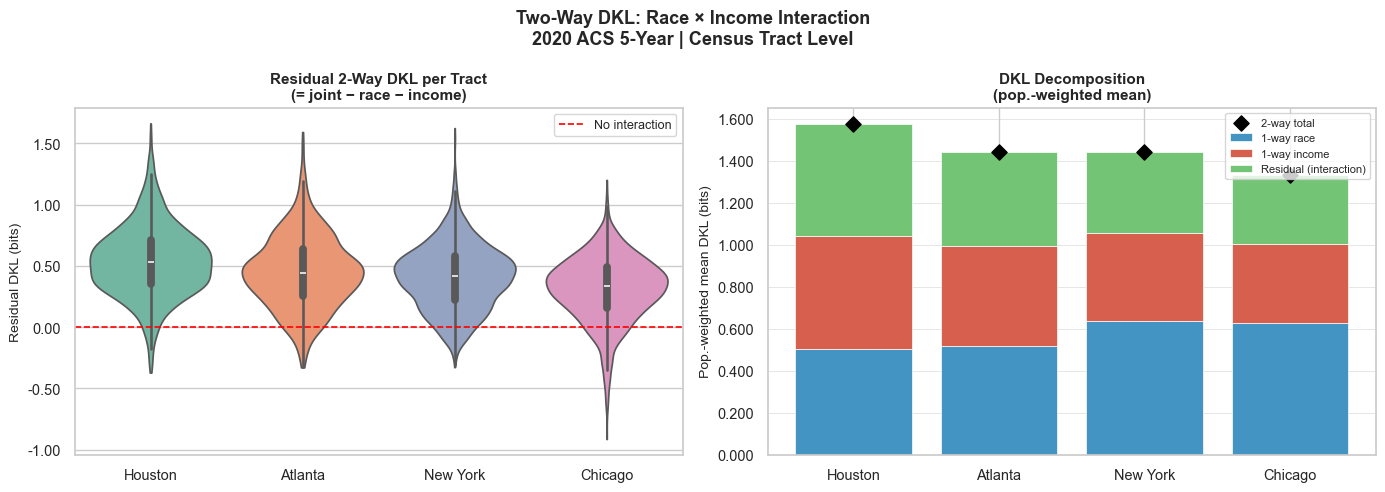

In [12]:
# ── Plot 4: Residual distribution — violin plot by city ──────────────────────
#
# The residual (2-way - race - income) shows the *interaction* component:
# how much additional sorting exists for specific race × income combinations
# beyond what race and income sorting predict independently.

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Violin plot of residual across tracts
ax = axes[0]
plot_data = tract_dkl[tract_dkl['tract_total'] > 50].copy()   # exclude tiny tracts
city_order = (
    plot_data.groupby('city_label')['residual']
    .median().sort_values(ascending=False).index.tolist()
)

sns.violinplot(
    data=plot_data, x='city_label', y='residual', order=city_order,
    palette='Set2', inner='box', ax=ax, cut=0
)
ax.axhline(0, color='red', linestyle='--', linewidth=1.2, label='No interaction')
ax.set_xlabel('')
ax.set_ylabel('Residual DKL (bits)', fontsize=10)
ax.set_title('Residual 2-Way DKL per Tract\n(= joint − race − income)', fontsize=11, fontweight='bold')
ax.legend(fontsize=9)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

# Panel B: Stacked bar — decomposition of pop-weighted 2-way DKL
ax = axes[1]
decomp = summary.set_index('city_label')[[
    'DKL 1-way race', 'DKL 1-way income', 'Residual (interaction)'
]].loc[city_order]

colors = ['#4393c3', '#d6604d', '#74c476']
bottom = np.zeros(len(decomp))
for col, color in zip(decomp.columns, colors):
    vals = decomp[col].values
    ax.bar(decomp.index, vals, bottom=bottom, color=color,
           label=col.replace('DKL ', ''), edgecolor='white', linewidth=0.5)
    bottom += vals

# 2-way total markers
totals = summary.set_index('city_label').loc[city_order, 'DKL 2-way (joint race×income)']
ax.scatter(range(len(city_order)), totals.values, color='black', zorder=5,
           s=60, marker='D', label='2-way total')

ax.set_ylabel('Pop.-weighted mean DKL (bits)', fontsize=10)
ax.set_title('DKL Decomposition\n(pop.-weighted mean)', fontsize=11, fontweight='bold')
ax.legend(fontsize=8, loc='upper right')
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))
ax.grid(axis='y', linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)

fig.suptitle(
    'Two-Way DKL: Race × Income Interaction\n2020 ACS 5-Year | Census Tract Level',
    fontsize=13, fontweight='bold'
)
plt.tight_layout()
plt.show()

In [13]:
# ── Plot 5: Choropleth maps — 2-way DKL and residual ─────────────────────────
#
# Requires tract-level shapefiles. Uses Census TIGER 2020 cartographic boundaries.

import geopandas as gpd
import contextily as ctx
import requests, zipfile, io, tempfile

TRACT_CACHE = DATA_DIR / 'two_way_dkl' / 'tracts_2020'
TRACT_CACHE.mkdir(parents=True, exist_ok=True)


def download_tracts(state_fips, cache_dir):
    sf = str(state_fips).zfill(2)
    fpath = cache_dir / f'tl_2020_{sf}_tract.parquet'
    if fpath.exists():
        return gpd.read_parquet(fpath)
    url = f'https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_{sf}_tract.zip'
    r = requests.get(url, timeout=120)
    r.raise_for_status()
    # Write ZIP to disk, then read via zip:// scheme (pyogrio-compatible)
    zip_path = cache_dir / f'tl_2020_{sf}_tract.zip'
    zip_path.write_bytes(r.content)
    try:
        gdf = gpd.read_file(f'zip://{zip_path}!tl_2020_{sf}_tract.shp')
    finally:
        zip_path.unlink(missing_ok=True)
    gdf = gdf.rename(columns=str.lower)
    gdf['geoid'] = gdf['geoid'].str.zfill(11)
    gdf = gdf[['geoid','geometry']]
    gdf.to_parquet(fpath, index=False)
    return gdf


print('Downloading tract shapefiles …')
tract_gdfs = []
for sf in study_state_fips:
    try:
        tract_gdfs.append(download_tracts(sf, TRACT_CACHE))
        print(f'  {sf} ✓')
    except Exception as e:
        print(f'  {sf} ERROR: {e}')

tracts_gdf = pd.concat(tract_gdfs, ignore_index=True)
tracts_gdf = gpd.GeoDataFrame(tracts_gdf, geometry='geometry', crs='EPSG:4326')
print(f'Total tracts: {len(tracts_gdf):,}')

  13 ✓


  17 ✓


  18 ✓


  34 ✓


  36 ✓


  42 ✓


  48 ✓


  55 ✓
Total tracts: 27,233


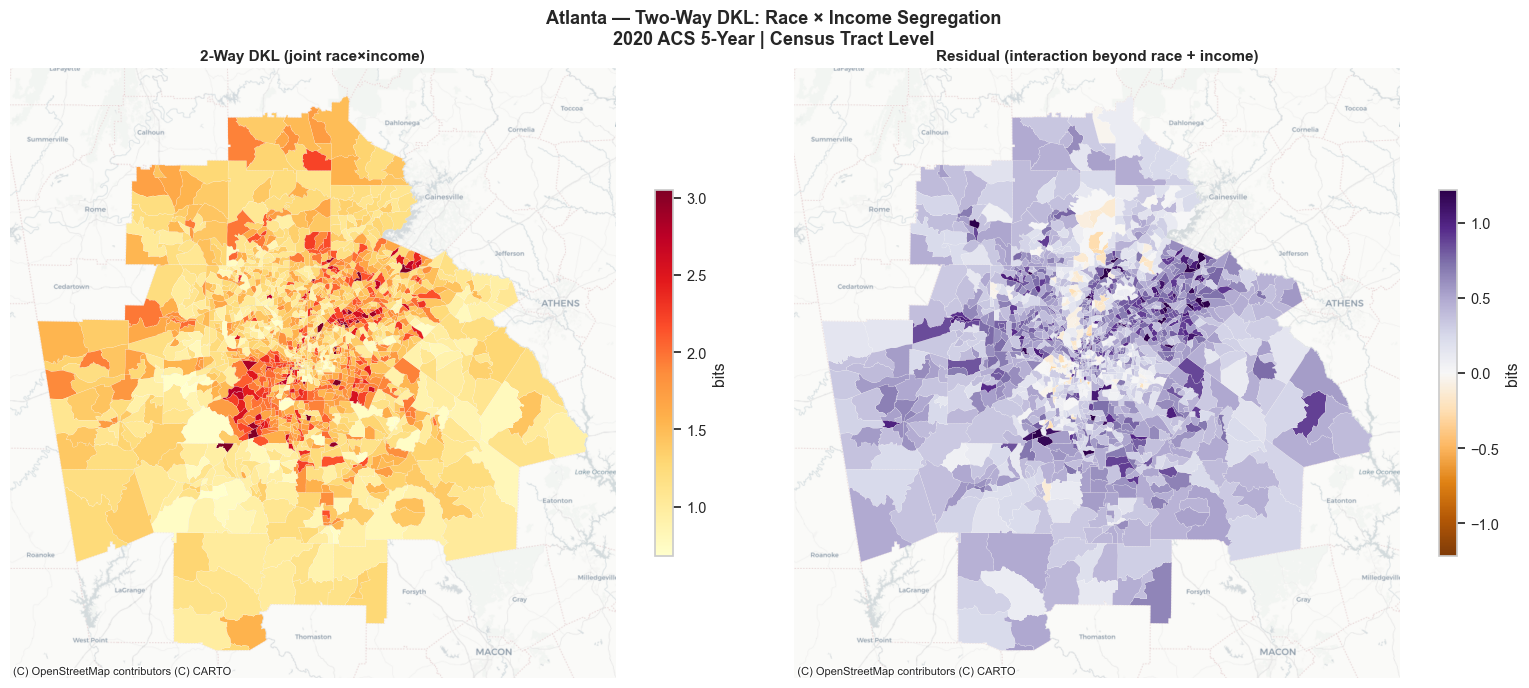

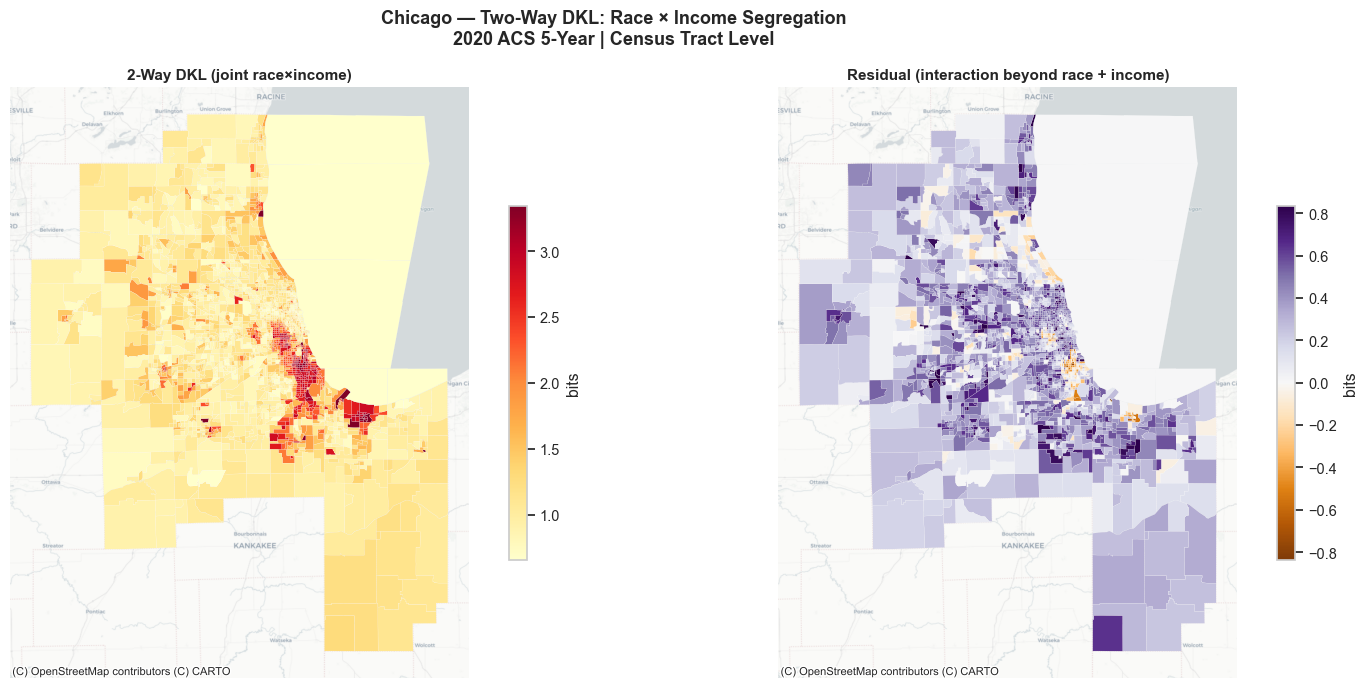

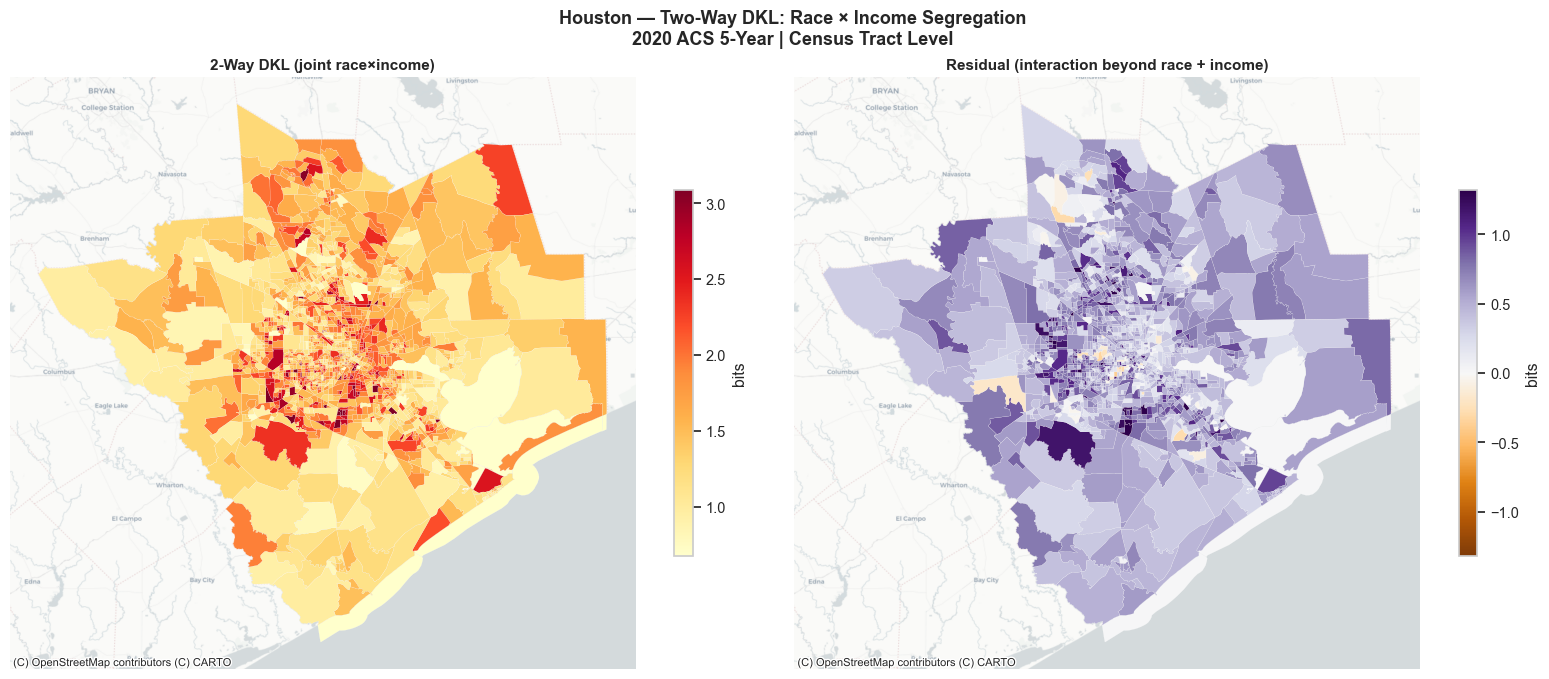

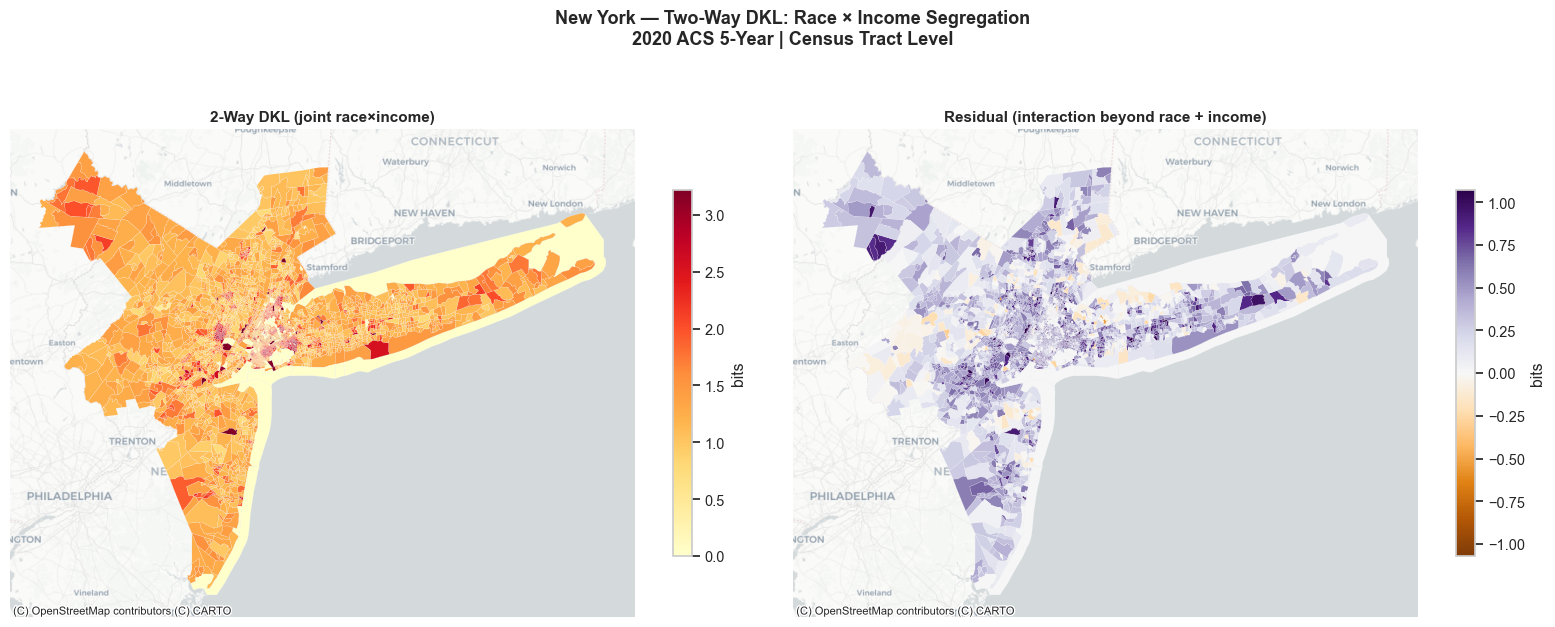

In [14]:
# ── Choropleth: 2-way DKL and residual for each study city ───────────────────

# Join DKL to geometry
tract_geo = tracts_gdf.merge(
    tract_dkl[['tract_fips','city_label','dkl_2way','residual','tract_total']],
    left_on='geoid', right_on='tract_fips', how='inner'
)
tract_geo = tract_geo.to_crs('EPSG:3857')

COLS   = ['dkl_2way', 'residual']
TITLES = ['2-Way DKL (joint race×income)', 'Residual (interaction beyond race + income)']
CMAPS  = ['YlOrRd', 'PuOr']

for city in cities_list:
    sub = tract_geo[tract_geo['city_label'] == city].copy()
    if sub.empty:
        continue

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    for ax, col, title, cmap in zip(axes, COLS, TITLES, CMAPS):
        vmin = sub[col].quantile(0.01)
        vmax = sub[col].quantile(0.99)

        if col == 'residual':
            # Diverging: centre at 0
            bound = max(abs(vmin), abs(vmax))
            vmin, vmax = -bound, bound

        sub.plot(
            column=col, ax=ax, cmap=cmap,
            vmin=vmin, vmax=vmax,
            linewidth=0.1, edgecolor='white',
            legend=True,
            legend_kwds={'label': 'bits', 'shrink': 0.6, 'orientation': 'vertical'},
            missing_kwds={'color': 'lightgrey'},
        )
        try:
            ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom='auto')
        except Exception:
            pass
        ax.set_axis_off()
        ax.set_title(title, fontsize=11, fontweight='bold')

    fig.suptitle(
        f'{city} — Two-Way DKL: Race × Income Segregation\n'
        f'2020 ACS 5-Year | Census Tract Level',
        fontsize=13, fontweight='bold'
    )
    plt.tight_layout()
    plt.show()